In [1]:
import dicom
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

from scipy.interpolate import RegularGridInterpolator

In [2]:
dcm_ref = dicom.read_file("data_reference.dcm")
dcm_evl = dicom.read_file("data_evaluation.dcm")

In [3]:
def load_dose_from_dicom(dcm):
    pixel_reference = np.transpose(
        dcm.pixel_array, (2, 1, 0))
    dose = (
        pixel_reference * dcm.DoseGridScaling)
    
    return dose


dose_reference = load_dose_from_dicom(dcm_ref)
dose_evaluation = load_dose_from_dicom(dcm_evl)

In [4]:
def load_xyz_from_dicom(dcm):
    resolution = np.array(
        dcm.PixelSpacing).astype(float)
    dx = resolution[0]
    
    x = (
        dcm.ImagePositionPatient[0] + 
        np.arange(0, dcm.Rows * dx, dx))
    
    dy = resolution[1]
    y = (
        dcm.ImagePositionPatient[1] + 
        np.arange(0, dcm.Columns * dy, dy))
    
    z = (
        np.array(dcm.GridFrameOffsetVector) + 
        dcm.ImagePositionPatient[2])
    
    return x, y, z


x_reference, y_reference, z_reference = load_xyz_from_dicom(dcm_ref)
x_evaluation, y_evaluation, z_evaluation = load_xyz_from_dicom(dcm_evl)

In [5]:
coords_reference = (
    y_reference, x_reference, z_reference)

coords_evaluation = (
    y_evaluation, x_evaluation, z_evaluation)

In [6]:
distance_threshold = 3
distance_step_size = distance_threshold / 10

dose_threshold = 0.03 * np.max(dose_evaluation)
lower_dose_cutoff = np.max(dose_evaluation) * 0.2
maximum_test_distance = distance_threshold * 2

# Here starts internal function

With inputs:

 * `coords_reference`
 * `dose_reference`
 * `coords_evaluation`
 * `dose_evaluation`
 * `distance_threshold`
 * `dose_threshold`
 * `lower_dose_cutoff=0`
 * `distance_step_size=None` (default is 1/10th of `distance_threshold`)
 * `maximum_test_distance=None` (default is 2 * `distance_threshold` use `np.inf` to remove maximum)

In [7]:
reference_interpolation = RegularGridInterpolator(
    coords_reference, dose_reference
)

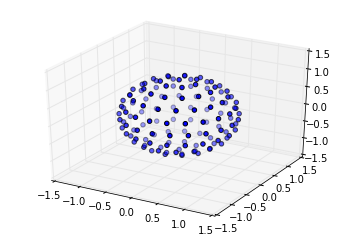

In [8]:
def coords_to_check_3d(distance, step_size):
    number_of_rows = np.floor(
        np.pi * distance / distance_step_size) + 1
    elevation = np.linspace(0, np.pi, number_of_rows)
    row_radii = distance * np.sin(elevation)
    row_circumference = 2 * np.pi * row_radii
    amount_in_row = np.floor(row_circumference / distance_step_size) + 1

    x = []; y = []; z = []
    for i, phi in enumerate(elevation):
        azimuth = np.linspace(0, 2*np.pi, amount_in_row[i] + 1)[:-1:]
        x.append(distance * np.sin(phi) * np.cos(azimuth))
        y.append(distance * np.sin(phi) * np.sin(azimuth))
        z.append(distance * np.cos(phi) * np.ones_like(azimuth))

    x = np.hstack(x)
    y = np.hstack(y)
    z = np.hstack(z)
    
    return x, y, z
    
x, y, z = coords_to_check_3d(1, distance_step_size)    
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z)

In [9]:
y, x, z = coords_evaluation
xx, yy, zz = np.meshgrid(x, y, z)
dose_evaluation = np.array(dose_evaluation)

dose_valid = dose_evaluation > lower_dose_cutoff
gamma_valid = np.ones_like(dose_evaluation).astype(bool)

running_gamma = np.inf * np.ones_like(dose_evaluation)

distance = 0

In [10]:
def find_min_dose_difference_at_distance_3d(x_test, y_test, z_test, 
                                            dose_test, distance, step_size):
    x_shift, y_shift, z_shift = coords_to_check_3d(
        distance, step_size)

    x_coords = x_test[None,:] + x_shift[:, None]
    y_coords = y_test[None,:] + y_shift[:, None]
    z_coords = z_test[None,:] + z_shift[:, None]
    
    all_points = np.concatenate(
        (y_coords[:,:,None], x_coords[:,:,None], z_coords[:,:,None]), 
        axis=2)
    
    dose_difference = np.array([
        reference_interpolation(points) - dose_test for 
        points in all_points
    ])
    min_dose_difference = np.min(np.abs(dose_difference), axis=0)
    
    return min_dose_difference


while True:
    x_valid = (
        (xx > np.min(x_reference) + distance) &
        (xx < np.max(x_reference) - distance))

    y_valid = (
        (yy > np.min(y_reference) + distance) &
        (yy < np.max(y_reference) - distance))
    
    z_valid = (
        (zz > np.min(z_reference) + distance) &
        (zz < np.max(z_reference) - distance))

    to_be_checked = (
        x_valid & y_valid & z_valid &
        dose_valid & gamma_valid
    )

    min_dose_diff = find_min_dose_difference_at_distance_3d(
        xx[to_be_checked], yy[to_be_checked], zz[to_be_checked],
        dose_evaluation[to_be_checked], 
        distance, distance_step_size)

    gamma_at_distance = np.sqrt(
        min_dose_diff ** 2 / dose_threshold ** 2 + 
        distance **2 / distance_threshold **2)

    running_gamma[to_be_checked] = np.min(
        np.vstack((
                gamma_at_distance, running_gamma[to_be_checked]
            )), axis=0)

    gamma_valid = running_gamma > distance / distance_threshold

    distance += distance_step_size
    
    if (np.sum(to_be_checked) == 0) | (distance > maximum_test_distance):
        break

In [11]:
gamma = running_gamma[~np.isinf(running_gamma)]

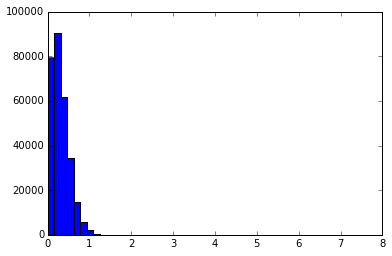

In [12]:
plt.hist(gamma, 50);

In [13]:
np.sum(gamma <= 1) / len(gamma)

0.99285482747442977

In [14]:
relevant_slice = (
    np.max(dose_evaluation, axis=(0, 1)) > 
    lower_dose_cutoff)
slice_start = np.max([
        np.where(relevant_slice)[0][0], 
        0])
slice_end = np.min([
        np.where(relevant_slice)[0][-1], 
        len(z_evaluation)])

Slice = -67.5


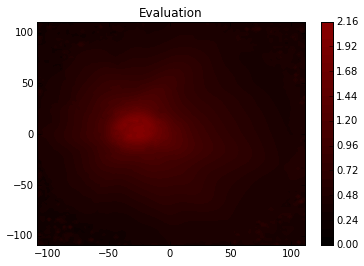

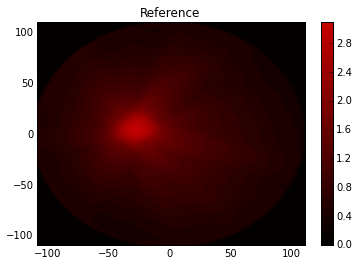

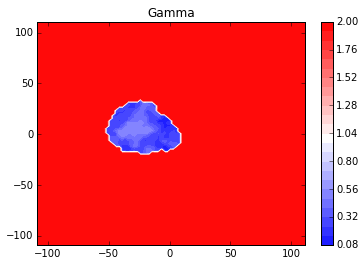



Slice = -55.0


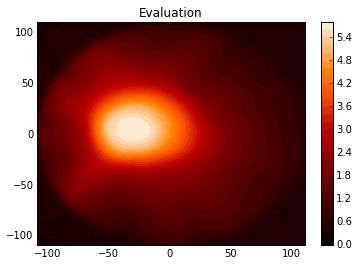

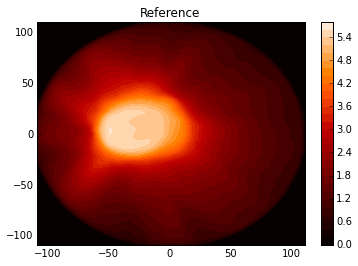

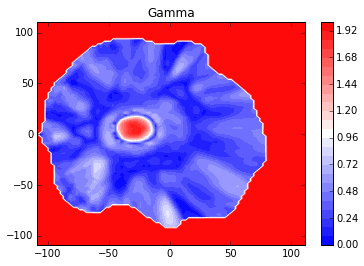



Slice = -42.5


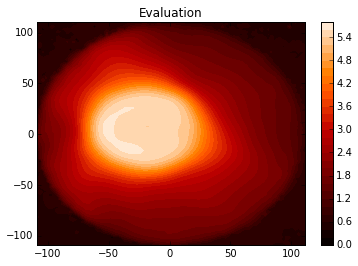

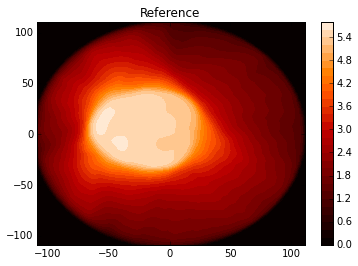

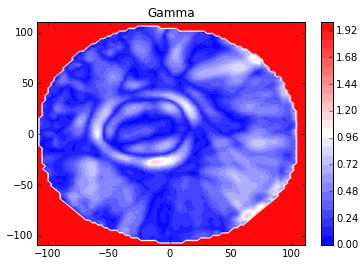



Slice = -30.0


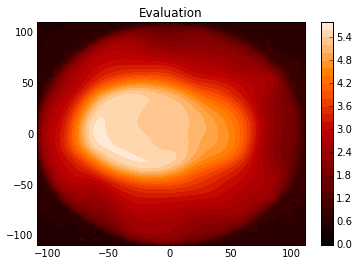

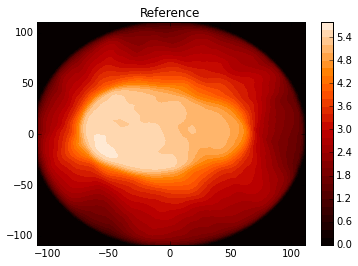

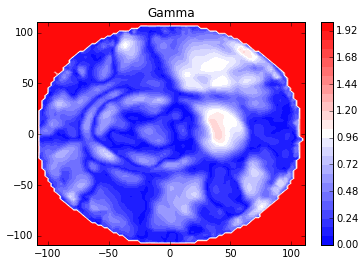



Slice = -17.5


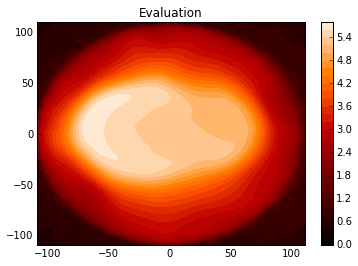

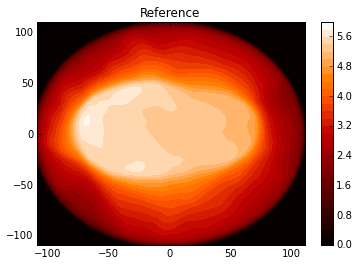

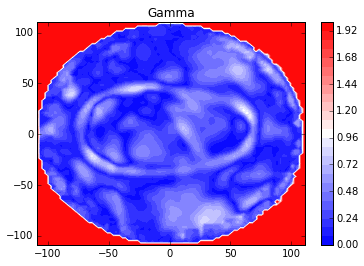



Slice = -5.0


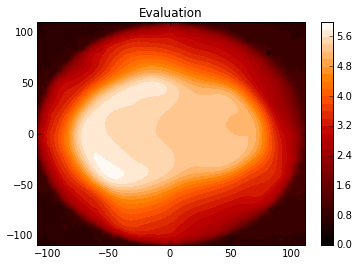

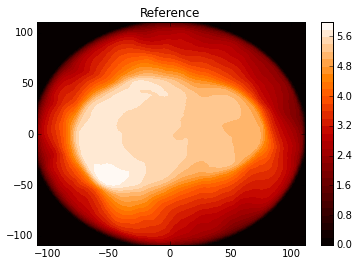

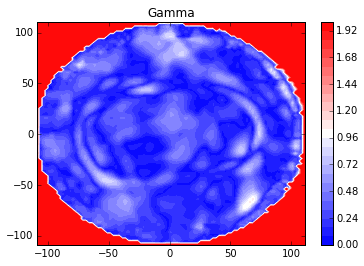



Slice = 7.5


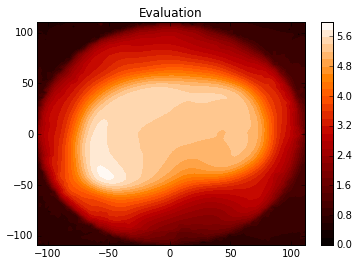

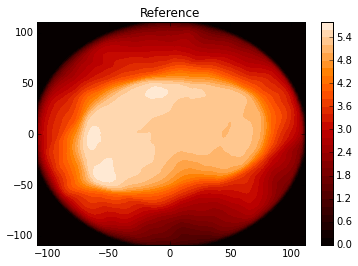

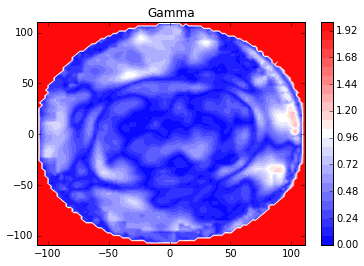



Slice = 20.0


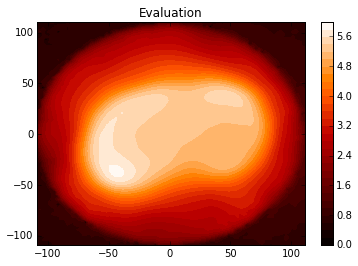

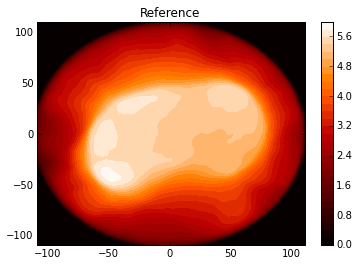

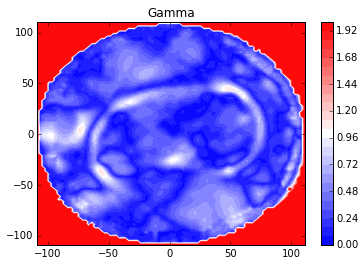



Slice = 32.5


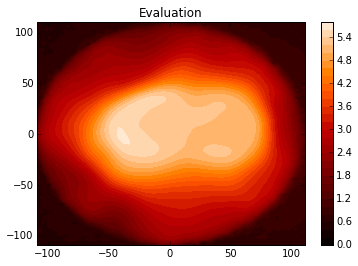

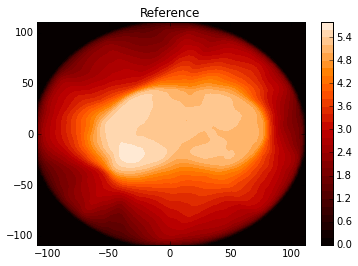

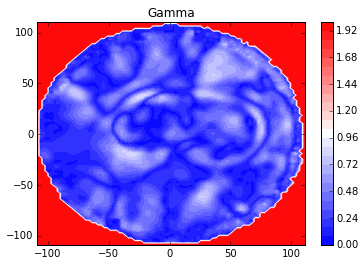



Slice = 45.0


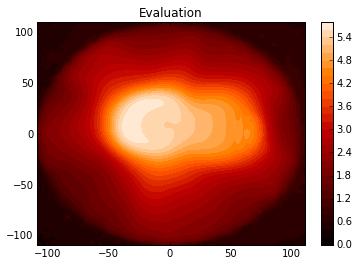

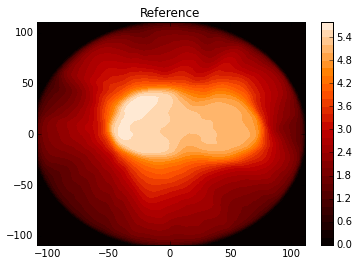

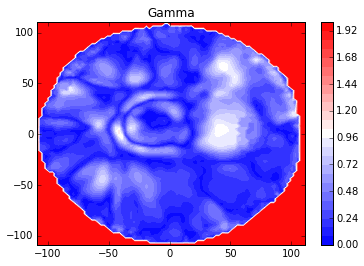



Slice = 57.5


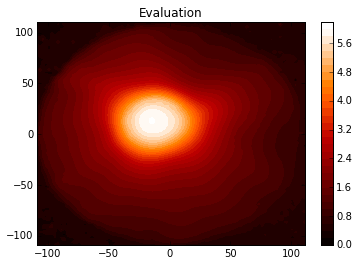

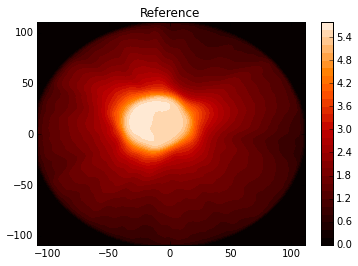

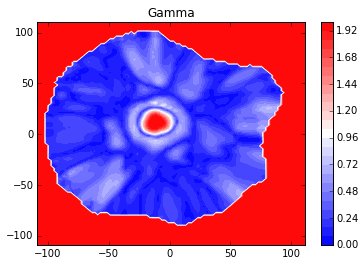



Slice = 70.0


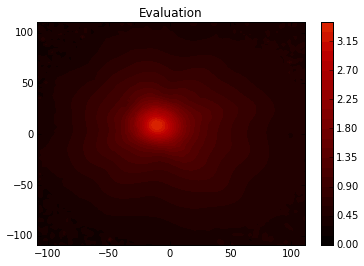

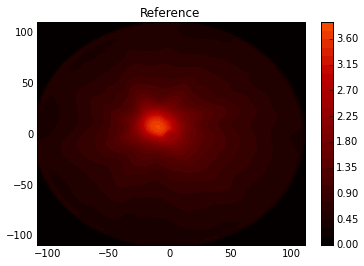

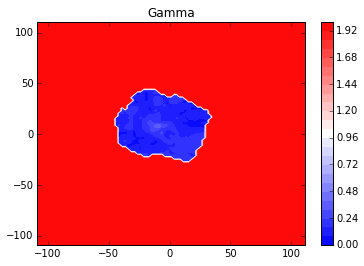

In [16]:
max_ref_dose = np.max(dose_reference)

draw_gamma = running_gamma.copy()
draw_gamma[draw_gamma > 2] = 2

for z_i in z_evaluation[slice_start:slice_end:5]:
    i = np.where(z_i == z_evaluation)[0][0]
    j = np.where(z_i == z)[0][0]
    print("======================================================================")
    print("Slice = {0}".format(z_i))  
   
    plt.contourf(
        x_evaluation, y_evaluation, dose_evaluation[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("Evaluation")
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_reference, y_reference, dose_reference[:, :, j], 30, 
        vmin=0, vmax=max_ref_dose, cmap=plt.get_cmap('gist_heat'))
    plt.title("Reference")  
    plt.colorbar()
    plt.show()
    
    plt.contourf(
        x_evaluation, y_evaluation, draw_gamma[:, :, i], 30, 
        vmin=0, vmax=2, cmap=plt.get_cmap('bwr'))
    plt.title("Gamma")    
    plt.colorbar()  
    plt.show()
    
    print("\n")